In [2]:
import pandas as pd
import numpy as np
import random
from math import sqrt
from math import e
from math import log
import matplotlib.pyplot as plt
import array
import time

'''IMP:
Units: h * dist - km/s
       h = 100 km/(s*Mpc)'''

pi = np.pi
freq = 5 * 1e12 #Hz. Freq of 60um band
r_s = 5 #in Mpc r_s/h
fm = np.log10(12) #log_10 of 1.2Jy in 0.1 Jy. Flux limit of the sample
L_s = 4*pi*r_s**2 * freq * fm
R_max = 80 #in Mpc
print('Freq:', freq, '\nr_s:', r_s, '\nFlux Limit:', fm)
print('Luminosity cut-off (L_s):', L_s, '\nR_max:', R_max)

data = pd.read_csv("Data/HEASARC/IRAS Galaxies_1.tsv", delimiter = "\t")

Freq: 5000000000000.0 
r_s: 5 
Flux Limit: 1.0791812460476249
Luminosity cut-off (L_s): 1695173937237548.8 
R_max: 80


In [3]:
'''Sorting Data to be used - Part 1'''

objclass = data["class"]
objext = data["extend_flag"]
objredshift = data["helio_velocity"]
objf60qual = data["micron_flux_60_flag"]
objf12_1, objf25_1, objf100_1 = [], [], []
objf60_1 = []

#czarr_i = c * z units km/s
czarr1, czarr = [], []
for i in range(len(objclass)):
    if (objclass[i] == "GALAXY" and objext[i] == 0 and objf60qual[i] == 2 or objf60qual[i] == 3):
        if objredshift[i] == 0.0: continue
        czarr1.append(float(objredshift[i]))
        objf12_1.append(float(data["micron_flux_12"][i]))
        objf25_1.append(float(data["micron_flux_25"][i]))
        objf60_1.append(float(data["micron_flux_60"][i]))
        objf100_1.append(float(data["micron_flux_100"][i]))

objf12, objf25, objf100 = [], [], []
objf60 = []
for i in range(len(czarr1)):
    if (float(czarr1[i]) >= 0.0 and str(czarr1[i]) != 'nan'):
        czarr.append(czarr1[i]) #final zarr to be used
        objf12.append(objf12_1[i])
        objf25.append(objf25_1[i])
        objf60.append(objf60_1[i])
        objf100.append(objf100_1[i])
        
c = 299792458 #m/s Speed of light

zarr = [float(1e3*x/c) for x in czarr] #redshift array
print(len(zarr))

5667


In [4]:
'''Comoving distance from redshift, Chi(z)'''

H0 = 100.
OM_m, OM_r, OM_de, OM_k = 0.28, 8.24e-5, 0.72, 0

def H(z):
    Hz = H0 * (1+z) * sqrt(OM_m*(1+z) + OM_r*(1+z)**2. + OM_de/(1+z)**2. + OM_k)
    return Hz

def dist(z1_, z2_):
    n = 1000
    ztemp = np.empty(n+1)
    h = (z2_ - z1_)/float(n)
    ztemp[0] = z1_
    f_even, f_odd = 0., 0.
    for i in range(1, n+1):
        ztemp[i] = z1_ + float(i) * h
    for i in range(1, int(n/2)):
        zz = ztemp[2*i]
        f_even = f_even + (1. / H(zz))
    for i in range(1, int(n/2)+1):
        zz = ztemp[2*i-1]
        f_odd = f_odd + (1. / H(zz))
    fz1 = (1. / H(z1_))
    fz2 = (1. / H(z2_))
    integral = h/3. * c / 1e3 * (fz1 + 2.*f_even + 4.*f_odd + fz2)
    return integral

#Comoving distance array
distarr = [float(dist(0., x)) for x in zarr] #values in Mpc
print(len(distarr))

5667


In [5]:
'''Sorting Data to be used - Part 2'''

#subset distances in [r_s, R_max] for use in fitting
darr1, obj1f60 = [], []
for i in range(len(distarr)):
    if (distarr[i] >= r_s and distarr[i] <= R_max and objf60[i] >= fm):
        darr1.append(distarr[i])
        obj1f60.append(objf60[i])
print(len(darr1))

3375


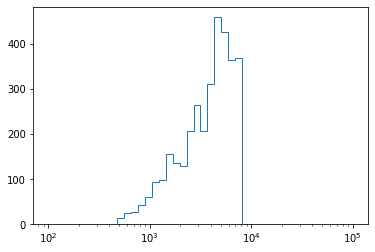

In [6]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.hist(100*np.array(darr1), bins=np.logspace(np.log10(1e2),np.log10(1e5), 45), histtype = 'step')
#ax1.plot(distvals, phivals)
ax1.set_xscale('log')
#ax1.set_ylim(0, 20)
#ax1.set_xlim(0, 1000)
plt.show()

In [7]:
#f60 = [0.1*10**x for x in obj1f60] #in Jy.
darr1 = np.array(darr1)
f60 = np.array(obj1f60) #in log_10 of flux in 0.1 Jy.
lumino = 4*pi*darr1**2 * freq * f60
#fm = 1.2

#Only for testing until we get flux limit:
#fm = min(f60) #log_10 of 1.2Jy in 0.1 Jy. Flux limit of the sample
#L_s = 4*np.pi*r_s**2 * freq * fm
#--

#Yet to convert to numpy arrays
def phi(r, alpha, beta, r_star): #Galaxy Selection function
    A = r_s**(2*alpha) * (1 + (r_s**2./r_star**2.))**beta
    return A * r**(-2*alpha) * (1 + (r**2./r_star**2.))**-beta
#------------------------------

def PSI(L_arr, alpha, beta, r_star): #Cumulative Luminosity function
    L_star = 4*pi*r_star**2. * freq * fm
    C = 1 #
    return C * (L_arr/L_star)**-alpha * (1 + L_arr/L_star)**-beta

def PHI(L_arr, alpha, beta, r_star): #Luminosity function
    L_star = 4*pi*r_star**2. * freq * fm
    return (alpha/L_arr + beta/(L_star + L_arr)) * PSI(L_arr, alpha, beta, r_star)

def probf(r_arr, L_arr, alpha, beta, r_star): #Probability function "f(Li|ri)"
    size = len(r_arr)
    Lm = np.maximum(L_s, 4*pi*r_arr**2 * freq * fm)
    return_array = (L_arr >= Lm) * PHI(L_arr, alpha, beta, r_star) / PSI(Lm, alpha, beta, r_star)
    return return_array
    
#Likelihood function
#returns a POSITIVE value (COST that the algorithm pays at the given vales of parameters)
def lhdfunc(params):
    alpha, beta, r_star = params[0], params[1], params[2]
    f = probf(darr1, lumino, alpha, beta, r_star)
    value = np.sum(np.log(f))
    #print('COST:', -2 * value)
    return -2 * value

In [8]:
#Getting L matrix

L = np.load('Cholesky_decomp_L.npy')
scale_fac = 2*0.3

In [9]:
####---- Monte-Carlo Minimization Functions----####

def mcmc_min(niter, ini_vals):
    #niter = 1e6
    i, k = 0, 0
    
    alpha, beta, r_star = ini_vals[0], ini_vals[1], ini_vals[2] #initial guess
    
    acc_alphas, acc_betas, acc_r_stars = np.empty(0), np.empty(0), np.empty(0) #arrays to store all accepted parameter values
    costarr = np.empty(0) #array to store cost (from likelihood func) at all accepted values
    
    f_old = lhdfunc(array.array('f', [alpha, beta, r_star])) #OLD COST (from likelihood func)
    
    while i < int(niter):
        eta = np.random.normal(size = (3, 1))
        inc = scale_fac * np.dot(L, eta)
        inc_alpha, inc_beta, inc_r_star = inc[0, 0], inc[1, 0], inc[2, 0] #increments to parameters
        #increments based on new proposal function:
        #params[i+1] = params[i] + scale_fac * matmul(L x eta)
        #where, eta is a vector of Gaussian variates
    
        guess = array.array('f', [alpha + inc_alpha, beta + inc_beta, r_star + inc_r_star]) #new parameters
        f_new = lhdfunc(guess) #NEW COST (from likelihood func)
    
        #print('f_old =', f_old, 'f_new =', f_new)
        #f_ratio = e**(-f_new) / e**(-f_old) #"Gives wrong value due to large power of e"
        #print('f_ratio =', f_ratio)
    
        differ_f = f_new - f_old #Using difference method as above commented code doesn't work
    
        #if (f_ratio >= 1): #Accept if f_ratio >= 1
        if differ_f <= 0: #"OR" Accept if differ_f <= 0
            alpha, beta, r_star = alpha + inc_alpha, \
            beta + inc_beta, r_star + inc_r_star #Accept the parameters
            acc_alphas = np.insert(acc_alphas, k, alpha)
            acc_betas = np.insert(acc_betas, k, beta)
            acc_r_stars = np.insert(acc_r_stars, k, r_star)
            costarr = np.insert(costarr, k, f_new)
            f_old = f_new #Set new COST as old COST for next iteration
            k += 1
    
        else: #Accept if uniform random number(u) <= f_ratio
            #"OR" Accept if u <= e**(-differ_f)
            u = random.uniform(0, 1)
            #if (u <= f_ratio):
            if (u <= e**(-differ_f)):
                alpha, beta, r_star = alpha + inc_alpha, beta + inc_beta, r_star + inc_r_star #Accept the parameters
                acc_alphas = np.insert(acc_alphas, k, alpha)
                acc_betas = np.insert(acc_betas, k, beta)
                acc_r_stars = np.insert(acc_r_stars, k, r_star)
                costarr = np.insert(costarr, k, f_new)
                f_old = f_new #Set new COST as old COST for next iteration
                k += 1
    
        i += 1
        if (i % 2e4 == 0): print('Iter: %d K, \tcurrent acc_ratio = %.3f' % (i/1e3, k/i))
    
    accratio = k/niter
    print("Number of accepted values: %d out of %d" % (k, niter))
    print("Acceptance ratio is %.3f" % accratio)
    
    return [k, acc_alphas, acc_betas, acc_r_stars, costarr]

def plot_min(params, se, ini_vals, mean, std): #se = [start, end]
    costarr, acc_alphas, acc_betas, acc_r_stars = params[0], params[1], params[2], params[3]
    
    figure = plt.figure(figsize = (12, 7))
    
    ax1 = figure.add_subplot(221)
    ax1.plot(costarr[se[0]:se[1]])
    ax1.set_title('COST')
    
    ax2 = figure.add_subplot(222)
    ax2.plot(acc_alphas[se[0]:se[1]])
    ax2.set_title('alpha')
    
    ax3 = figure.add_subplot(223)
    ax3.plot(acc_betas[se[0]:se[1]])
    ax3.set_title('beta')
    
    ax4 = figure.add_subplot(224)
    ax4.plot(acc_r_stars[se[0]:se[1]])
    ax4.set_title('r_star')
    
    figure.suptitle('Initial parameter values: alpha = %.2f, beta = %.2f, rstar = %.2f\
    \nBest-fit values: alpha = %.3f +- %.3f, beta = %.3f +- %.3f, rstar = %.3f +- %.3f' \
                    % (ini_vals[0], ini_vals[1], ini_vals[2], mean[0], std[0], \
                       mean[1], std[1], mean[2], std[2]), fontsize = 14)
    
    plt.savefig('IC_alpha_%.2f_beta_%.2f_rstar_%.2f.png' % (ini_vals[0], ini_vals[1], ini_vals[2]))

In [12]:
#Run MCMC Minimization for N_chain chains

N_chain = 10
niter = int(6e4)

'''actual values are:
alpha = 0.527 +- 0.034, beta = 1.78 +- 0.078, r_star = 44.00 +- 2.30'''

'''my values for Initial Chain:
alpha = 0.4640 +- 0.0294, beta = 2.0477 +- 0.1321, r_star = 71.3751 +- 5.8127'''

#Initial values within 10 sigma of Initial Chain
initialal = np.linspace(0.2, 0.7, N_chain+1)
initialbt = np.linspace(1.2, 2.8, N_chain+1)
initialrs = np.linspace(30, 110, N_chain+1)

#Arrays to store accepted parameter values
alpha2Darr, beta2Darr, rstar2Darr, cost2Darr = np.zeros([N_chain, niter]), \
np.zeros([N_chain, niter]), np.zeros([N_chain, niter]), np.zeros([N_chain, niter])
#different chains are stored in rows
#1st column in each row denotes the number of accepted values in the chain
#2nd column onwards, accepted values in that chain are stored.

#Mean and std for each chain.
u_al, u_bt, u_rs = np.zeros(N_chain), np.zeros(N_chain), np.zeros(N_chain)
std_al, std_bt, std_rs = np.zeros(N_chain), np.zeros(N_chain), np.zeros(N_chain)

np.random.seed(0)

for i in range(N_chain):
    print('Starting Chain', i+1)
    print('IC: alpha = %.2f, beta = %.2f, r_star = %.2f' % (initialal[i], initialbt[i], initialrs[i]))
    
    ini_vals = [initialal[i], initialbt[i], initialrs[i]] #initial values
    
    return_arr = mcmc_min(niter, ini_vals) #MCMC minimization
    
    #Store accepted parameter values
    k, alphas, betas, rstars, costarr = return_arr[0], return_arr[1], return_arr[2], return_arr[3], return_arr[4]
    alpha2Darr[i, 0], beta2Darr[i, 0], rstar2Darr[i, 0], cost2Darr[i, 0] = k, k, k, k
    alpha2Darr[i, 1:k+1], beta2Darr[i, 1:k+1], rstar2Darr[i, 1:k+1] = alphas, betas, rstars
    cost2Darr[i, 1:k+1] = costarr
    
    burn_end = 1500
    
    #Calculate, store mean and std
    u_al[i], u_bt[i], u_rs[i] = np.mean(alphas[burn_end:]), np.mean(betas[burn_end:]), np.mean(rstars[burn_end:])
    std_al[i], std_bt[i], std_rs[i] = np.std(alphas[burn_end:]), np.std(betas[burn_end:]), np.std(rstars[burn_end:])
    u_params, std_params = [u_al[i], u_bt[i], u_rs[i]], [std_al[i], std_bt[i], std_rs[i]] #bundle mean, std for further use
    
    #plot_params = [costarr, alphas, betas, rstars]
    #plot_min(plot_params, [0, k], ini_vals, u_params, std_params) #Save plots
    
    print('\nMean +- sigma parameter values for Chain %d:' % (i+1))
    print('alpha \t= %.4f +- %.4f' % (u_al[i], std_al[i]))
    print('beta \t= %.4f +- %.4f' % (u_bt[i], std_bt[i]))
    print('r_star \t= %.4f +- %.4f' % (u_rs[i], std_rs[i]))
    
    #temp = input('%d chain(s) done! Plot saved.\nPress <ENTER> to proceed.' % (i+1))
    print('\n')

print(N_chain, 'chain(s) done successfully!')

Starting Chain 1
IC: alpha = 0.20, beta = 1.20, r_star = 30.00
Iter: 20 K, 	current acc_ratio = 0.621
Iter: 40 K, 	current acc_ratio = 0.622
Iter: 60 K, 	current acc_ratio = 0.624
Number of accepted values: 37457 out of 60000
Acceptance ratio is 0.624

Mean +- sigma parameter values for Chain 1:
alpha 	= 0.4653 +- 0.0288
beta 	= 2.0584 +- 0.1340
r_star 	= 71.8736 +- 5.9203


Starting Chain 2
IC: alpha = 0.25, beta = 1.36, r_star = 38.00
Iter: 20 K, 	current acc_ratio = 0.626
Iter: 40 K, 	current acc_ratio = 0.628
Iter: 60 K, 	current acc_ratio = 0.627
Number of accepted values: 37609 out of 60000
Acceptance ratio is 0.627

Mean +- sigma parameter values for Chain 2:
alpha 	= 0.4639 +- 0.0282
beta 	= 2.0541 +- 0.1314
r_star 	= 71.5342 +- 5.7093


Starting Chain 3
IC: alpha = 0.30, beta = 1.52, r_star = 46.00
Iter: 20 K, 	current acc_ratio = 0.630
Iter: 40 K, 	current acc_ratio = 0.629
Iter: 60 K, 	current acc_ratio = 0.626
Number of accepted values: 37549 out of 60000
Acceptance ratio i

In [14]:
#Overall mean and std

al_list, bt_list, rs_list = [], [], []
num_all = 0
burn_end = 2000
for i in range(N_chain):
    k = int(alpha2Darr[i, 0])
    al_list.extend(alpha2Darr[i, burn_end:k+1])
    bt_list.extend(beta2Darr[i, burn_end:k+1])
    rs_list.extend(rstar2Darr[i, burn_end:k+1])
mean_alpha, std_alpha = np.mean(al_list), np.std(al_list)
mean_beta, std_beta = np.mean(bt_list), np.std(bt_list)
mean_r_star, std_r_star = np.mean(rs_list), np.std(rs_list)
print('alpha \t= %.4f +- %.4f' % (mean_alpha, std_alpha))
print('beta \t= %.4f +- %.4f' % (mean_beta, std_beta))
print('r_star \t= %.4f +- %.4f' % (mean_r_star, std_r_star))

alpha 	= 0.4648 +- 0.0284
beta 	= 2.0560 +- 0.1317
r_star 	= 71.7144 +- 5.7952


In [17]:
#Save accepted parameter lists

np.savez('MC_%dchains_iter_%deach.npz' % (N_chain, niter),
         burn = burn_end,
         ini_alpha = initialal,
         ini_beta = initialbt,
         ini_r_star = initialrs,
         mean_alpha = u_al,
         std_alpha = std_al,
         mean_beta = u_bt,
         std_beta = std_bt,
         mean_r_star = u_rs,
         std_r_star = std_rs,
         alpha_arr = alpha2Darr,
         beta_arr = beta2Darr,
         r_star_arr = rstar2Darr,
         cost_arr = cost2Darr
        )
print('Okay! Saved!')

Okay! Saved!


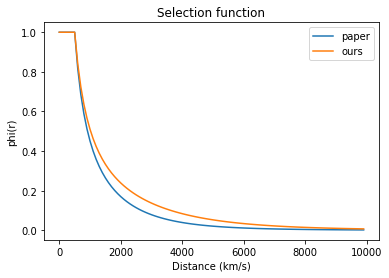

In [19]:
#Plot Selection Function

#distvals = np.logspace(np.log10(1e2),np.log10(1e5), 45)
distvals = np.arange(5, 100, 1)
distvalsplot = np.arange(0, 10000, 100)

alpha_val, beta_val, r_star_val = 0.527, 1.78, 44
phivals_paper = [phi(x, alpha_val, beta_val, r_star_val) for x in distvals]
phivals_paper = np.insert(phivals_paper, 0, [1, 1, 1, 1, 1])

alpha_val, beta_val, r_star_val = mean_alpha, mean_beta, mean_r_star
phivals_mine = [phi(x, alpha_val, beta_val, r_star_val) for x in distvals]
phivals_mine = np.insert(phivals_mine, 0, [1, 1, 1, 1, 1])

plt.plot(distvalsplot, phivals_paper, label = 'paper')
plt.plot(distvalsplot, phivals_mine, label = 'ours')

#plt.yscale('log')
plt.legend()
plt.title('Selection function')
plt.xlabel('Distance (km/s)')
plt.ylabel('phi(r)')
plt.savefig('selection_fn_paper+ours')
plt.show()

In [2]:
#Get histogram
def histogram(param, chain_num, nbins=11): #param is 2D array
    burn_end = 1500
    nvals = int(param[chain_num-1, 0])
    parr = param[chain_num-1, 1+burn_end:nvals+1]
    
    tot_counts = nvals - burn_end
    counts, bins = np.histogram(parr, bins = nbins)
    plotcounts = np.insert(counts, -1, counts[-1])
    
    binwidth = bins[1] - bins[0]
    #plt.hist(parr, bins = 25)
    plt.step(bins, plotcounts, where = 'post')
    plt.xlim(bins[0]-binwidth, bins[-1]+binwidth)
    plt.show()
    
    return [bins, counts, tot_counts]

#Plot Selection function
def plot_phi(alpha, beta, r_star):
    distvals = np.arange(5, 100, 1)
    distvalsplot = np.arange(0, 10000, 100)
    
    phivals = [phi(x, alpha, beta, r_star) for x in distvals]
    phivals = np.insert(phivals, 0, [1, 1, 1, 1, 1])
    
    plt.plot(distvalsplot, phivals, label = \
             'alpha=%.2f, beta=%.2f, r_star=%.2f' % (alpha, beta, r_star))
    #plt.yscale('log')
    plt.legend()
    plt.title('Selection function')
    plt.xlabel('Distance (km/s)')
    plt.ylabel('phi(r)')
    #plt.savefig('zzz.png')
    plt.show()

#Get median value and 1 sigma errorbars
def find_errorbars(bins, counts, tot_counts):
    if int(np.sum(counts)) != tot_counts: print('Oopsieee!!!')
    sigmacount = 0.341 * tot_counts
    medianbin = np.argmax(counts)
    medianval = (bins[medianbin] + bins[medianbin+1])/2
    
    #upper-errorbar
    sumcounts = counts[medianbin]/2
    for i in range(medianbin+1, len(counts)):
        sumcounts += counts[i]
        if (sumcounts >= sigmacount):
            upsigmaval = (bins[i] + bins[i+1])/2
            break
    uperror = upsigmaval - medianval
    
    #lower-errorbar
    sumcounts = counts[medianbin]/2
    for i in range(medianbin-1, 0, -1):
        sumcounts += counts[i]
        if (sumcounts >= sigmacount):
            losigmaval = (bins[i] + bins[i+1])/2
            break
    loerror = losigmaval - medianval
    
    return [medianval, uperror, loerror]

a = histogram(alpha2Darr, 5, 21)
print(a)
find_errorbars(a[0], a[1], a[2])

NameError: name 'np' is not defined

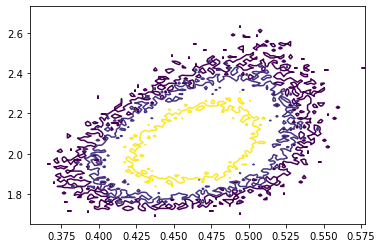

In [290]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as so
import scipy.ndimage

def find_confidence_interval(x, pdf, confidence_level):
    return pdf[pdf > x].sum() - confidence_level

def density_contour(xdata, ydata, nbins_x, nbins_y, ax=None, **contour_kwargs):
    """ Create a density contour plot.
    Parameters
    ----------
    xdata : numpy.ndarray
    ydata : numpy.ndarray
    nbins_x : int
        Number of bins along x dimension
    nbins_y : int
        Number of bins along y dimension
    ax : matplotlib.Axes (optional)
        If supplied, plot the contour to this axis. Otherwise, open a new figure
    contour_kwargs : dict
        kwargs to be passed to pyplot.contour()
    """

    H, xedges, yedges = np.histogram2d(xdata, ydata, bins=(nbins_x,nbins_y), normed=True)
    x_bin_sizes = (xedges[1:] - xedges[:-1]).reshape((1,nbins_x))
    y_bin_sizes = (yedges[1:] - yedges[:-1]).reshape((nbins_y,1))

    pdf = (H*(x_bin_sizes*y_bin_sizes))

    one_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.68))
    two_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.95))
    three_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.99))
    levels = [three_sigma, two_sigma, one_sigma]

    X, Y = 0.5*(xedges[1:]+xedges[:-1]), 0.5*(yedges[1:]+yedges[:-1])
    Z = pdf.T

    if ax == None:
        contour = plt.contour(X, Y, Z, levels=levels, origin="lower", **contour_kwargs)
    else:
        contour = ax.contour(X, Y, Z, levels=levels, origin="lower", **contour_kwargs)

    return contour

def test_density_contour():
    al_arr = alpha2Darr[0, 1501:int(alpha2Darr[0, 0])+1]
    bt_arr = beta2Darr[0, 1501:int(beta2Darr[0, 0])+1]
    al_arr = scipy.ndimage.zoom(al_arr, 1)
    bt_arr = scipy.ndimage.zoom(bt_arr, 1)
    density_contour(al_arr, bt_arr, 100, 100)
    plt.show()

test_density_contour()

# REDUNDANT CODES START HERE!!!!!

In [29]:
#Mean and Standard-deviation of Accepted Parameter Values

burn_end = 1500
mean_alpha, std_alpha = np.mean(acc_alphas[burn_end:limit]), np.std(acc_alphas[burn_end:limit])
mean_beta, std_beta = np.mean(acc_betas[burn_end:limit]), np.std(acc_betas[burn_end:limit])
mean_r_star, std_r_star = np.mean(acc_r_stars[burn_end:limit]), np.std(acc_r_stars[burn_end:limit])
print('alpha \t= %.4f +- %.4f' % (mean_alpha, std_alpha))
print('beta \t= %.4f +- %.4f' % (mean_beta, std_beta))
print('r_star \t= %.4f +- %.4f' % (mean_r_star, std_r_star))

NameError: name 'acc_alphas' is not defined

(0, 0.01)

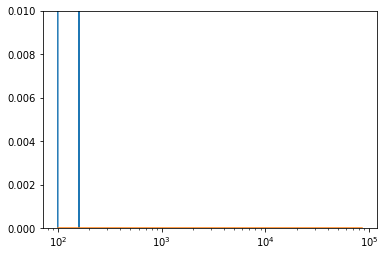

In [98]:
distvals = np.logspace(np.log10(1e2),np.log10(1e5), 45)
phivals = [phi(x, alpha, beta, r_star) for x in distvals]


hist, bin_edges = np.histogram(100*np.array(distarr), bins = distvals)
plt.plot(bin_edges[:-1], hist)
plt.plot(bin_edges[:-1], np.array(phivals[:-1]))
plt.xscale('log')
plt.ylim(0, 0.01)

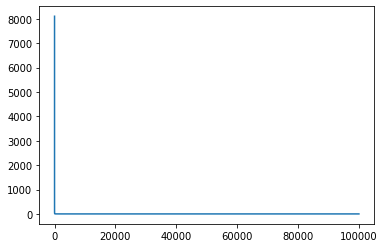

In [96]:
n1 = 

#byphivals = [1/x for x in phivals]
plt.plot(distvals, phivals)
plt.xscale('log')
plt.show()

In [116]:
for i in range(len(distarr)):
    if distarr[i] < r_s

TypeError: '<' not supported between instances of 'list' and 'int'

In [167]:
'''nintbin = 10
intdistarr = []
for i in range(len(distvals) - 1):
    intdistarr.extend(np.linspace(distvals[i], distvals[i+1], nintbin))
lumintdist = [4*np.pi*intdistarr[i]**2 * freq * f60[i] for i in range(len(distarr))]
    
densityvals = []
i, k = 0, 0
while i < len(distvals):
    for j in range(nintbin):
        densityvals[k] += PHI()'''

0.0

In [192]:
np.array([1, 2])/np.array([2, 4])

array([0.5, 0.5])

(0, 20)

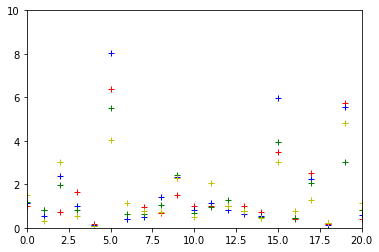

In [201]:
#plt.plot(objf12, 'ro')
#plt.plot(objf25, 'bo')
plt.plot(np.array(objf12[:-1])/np.array(objf12[1:]), 'r+')
plt.plot(np.array(objf25[:-1])/np.array(objf25[1:]), 'b+')
plt.plot(np.array(objf60[:-1])/np.array(objf60[1:]), 'g+')
plt.plot(np.array(objf100[:-1])/np.array(objf100[1:]), 'y+')
#plt.plot(objf100, 'go')
plt.ylim(0, 10)
plt.xlim(0, 20)

In [73]:
random.normalvariate(0, 0.01)

0.003216231249070716

In [90]:
array.array('', [1., 2, 3])

TypeError: integer argument expected, got float

In [12]:
less = 0
for i in range(len(f60)):
    if np.log10(12) > f60[i]: less += 1
less

172

In [13]:
len(f60)

3547

/home/pallav/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


-inf

False